#### RESOURCES: 

- [https://drive.google.com/drive/folders/1ZjNrTb7T_SsOdck76qDcd5OHkFEU0C6Q](Lip Dataset)
- [https://www.kaggle.com/datasets/agrigorev/clothing-dataset-full/data](Kaggle Clothing Dataset)
- [https://www.kaggle.com/datasets/hserdaraltan/deepfashion-inshop-clothes-retrieval] (DeepFashion-in-shop-clothes-retrieval)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from collections import OrderedDict

import torch
import torchvision
import torchvision.transforms as T

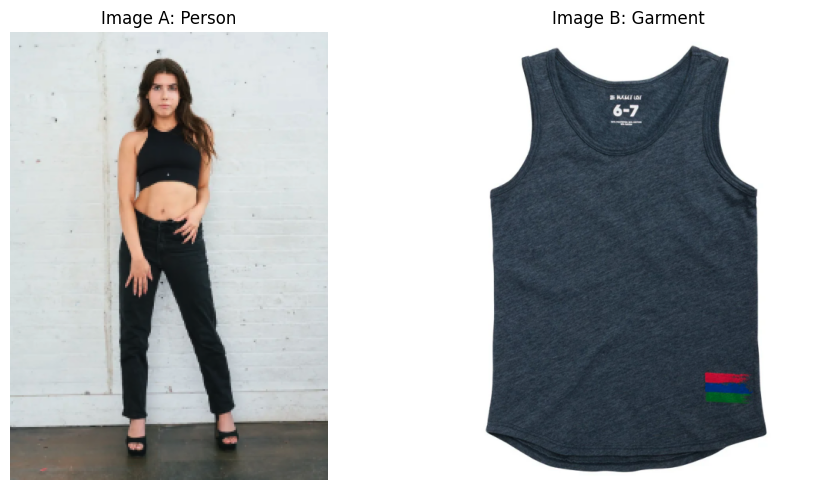

In [2]:
# Set paths
person_path = "sample-data/poses/pose1.png"   
garment_path = "sample-data/garments/tank-top.png"  

# Load images
img_person = Image.open(person_path).convert("RGB")
img_garment = Image.open(garment_path).convert("RGB")

# Visualize
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img_person)
axs[0].set_title("Image A: Person")
axs[1].imshow(img_garment)
axs[1].set_title("Image B: Garment")
for ax in axs: ax.axis("off")
plt.tight_layout()
plt.show()


#### **CLASSIFY GARMENT TYPE**

In [3]:
import clip

def get_garment_class(garment_path): 
    # Load model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)
    
    # Define garment category prompts
    garment_categories = ["long-sleeve-t-shirt", "short-sleeve-t-shirt", "pants", "short-dress", "long-dress", "short-skirt", "long-skirt", "shorts", "blouse", "crop-top", "tank-top"]
    text_inputs = torch.cat([clip.tokenize(f"a photo of a {g}") for g in garment_categories]).to(device)

    # Load and preprocess garment image
    img = Image.open(garment_path).convert("RGB")
    image_input = preprocess(img).unsqueeze(0).to(device)
    
    # Run CLIP
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)
    
        logits_per_image, _ = model(image_input, text_inputs)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    
    # Print results
    for i, cat in enumerate(garment_categories):
        print(f"{cat:>12}: {probs[0][i]*100:.2f}%")
    
    # Get top prediction
    garment_type = garment_categories[np.argmax(probs)]
    print("\n✅ Predicted Garment Type:", garment_type)

    return garment_type

get_garment_class(garment_path)

long-sleeve-t-shirt: 1.39%
short-sleeve-t-shirt: 10.78%
       pants: 0.00%
 short-dress: 0.00%
  long-dress: 0.00%
 short-skirt: 0.00%
  long-skirt: 0.00%
      shorts: 0.02%
      blouse: 0.00%
    crop-top: 0.29%
    tank-top: 87.50%

✅ Predicted Garment Type: tank-top


'tank-top'

In [4]:
# !git clone https://github.com/PeikeLi/Self-Correction-Human-Parsing.git
# !pip install opencv-python numpy torch torchvision yacs Pillow

### **HUMAN SEGMENTATION**

In [5]:
# some comman tensors/objects 

person_image = Image.open(person_path).convert('RGB')

# LIP-style preprocessing
transform = T.Compose([
    T.Resize((473, 473), interpolation=Image.BILINEAR),  # LIP default input size
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

LIP_LABELS = {
     0: 'Background', 1: 'Hat', 2: 'Hair', 3: 'Glove', 4: 'Sunglasses',
     5: 'Upper-clothes', 6: 'Dress', 7: 'Coat', 8: 'Socks', 9: 'Pants',
    10: 'Jumpsuits', 11: 'Scarf', 12: 'Skirt', 13: 'Face', 14: 'Left-arm',
    15: 'Right-arm', 16: 'Left-leg', 17: 'Right-leg', 18: 'Left-shoe', 19: 'Right-shoe'
}

#### **USING SINGLE-HUMAN-PARSING-LIP Model**

https://github.com/Yukun-Huang/Single-Human-Parsing-LIP?tab=readme-ov-file

In [6]:
import sys
sys.path.append('Single-Human-Parsing-LIP')

In [7]:
from net.pspnet import PSPNet

def load_pspnet_model(checkpoint_path, num_classes=20, backend='resnet50'):
    
    model = PSPNet(n_classes=num_classes, backend=backend, pretrained=False)
    
    raw_ckpt = torch.load(checkpoint_path, map_location='cuda')
    clean_state_dict = OrderedDict(
        (k.replace("module.", ""), v) for k, v in raw_ckpt.items()
    )
    model.load_state_dict(clean_state_dict)
    model.eval()
    return model

checkpoint_path = "Single-Human-Parsing-LIP/PSPNet_last"
model = load_pspnet_model(checkpoint_path)

torch.save(model.state_dict(), "Single-Human-Parsing-LIP/PSPNet_cleaned.pth")
model.load_state_dict(torch.load("Single-Human-Parsing-LIP/PSPNet_cleaned.pth"))
model.eval()

print("PSPNet model loaded and ready for inference.")


PSPNet model loaded and ready for inference.


Segmentation logits shape: torch.Size([1, 20, 480, 480])
Prediction map shape: (480, 480)


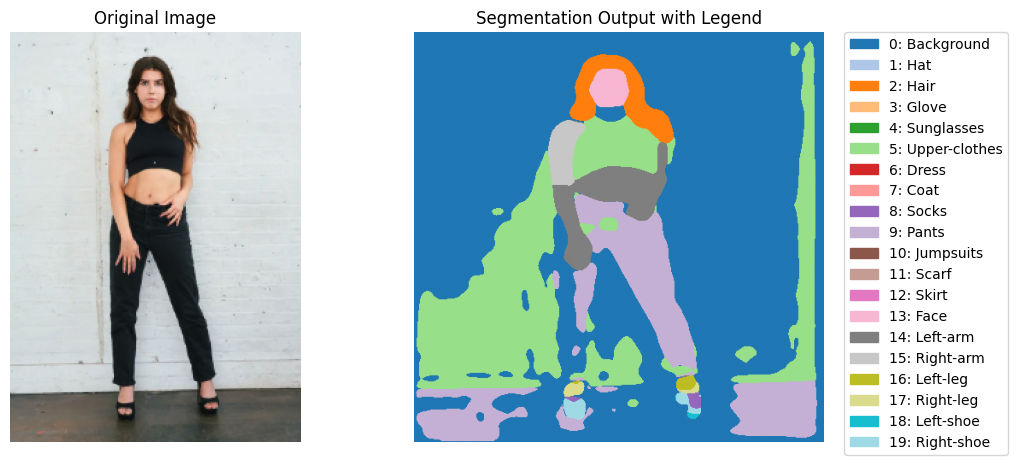

In [8]:
import matplotlib.patches as mpatches

input_tensor = transform(img_person).unsqueeze(0)  # add batch dim

# Run inference
with torch.no_grad():
    output = model(input_tensor)
    logits = output[0]
    print("Segmentation logits shape:", logits.shape)
    pred = torch.argmax(logits.squeeze(), dim=0).cpu().numpy()
    print("Prediction map shape:", pred.shape)

# Create a color map and legend patches
cmap = plt.get_cmap('tab20', 20)  # tab20 has 20 distinct colors
patches = [mpatches.Patch(color=cmap(i), label=f"{i}: {LIP_LABELS[i]}") for i in range(20)]

# Plot original + segmentation with legend
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_person)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(pred, cmap=cmap, vmin=0, vmax=19)
plt.title("Segmentation Output with Legend")
plt.axis("off")
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()


#### **USING SELF CORRECTION HUMAN PARSING**

##### **USING MODEL PRETRAINED ON LIP**

In [9]:
import sys
sys.path.append("Self-Correction-Human-Parsing")

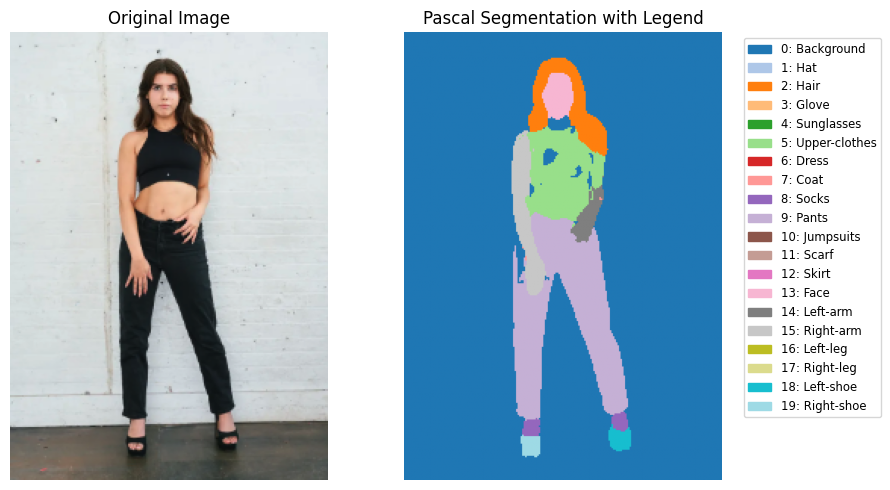

In [10]:
# --- SCHP repo imports ---
from networks import init_model
from utils.transforms import transform_logits


# Load SCHP model
def load_schp_model(checkpoint_path, num_classes=20):
    model = init_model('resnet101', num_classes=num_classes, pretrained=None)
    checkpoint = torch.load(checkpoint_path, map_location='cuda')
    state_dict = checkpoint["state_dict"]

    # Remove 'module.' prefix
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k.replace("module.", "")
        new_state_dict[name] = v

    model.load_state_dict(new_state_dict)
    model = model.cuda().eval()
    return model


def visualize_segmentation(image_path, model, labels=LIP_LABELS):
    image = Image.open(image_path).convert('RGB')
    orig_size = image.size
    input_tensor = transform(image).unsqueeze(0).cuda()

    with torch.no_grad():
        outputs = model(input_tensor)
        logits = outputs[0][0]

        import torch.nn.functional as F
        logits = F.interpolate(logits, size=orig_size[::-1], mode='bilinear', align_corners=True)
        parsing = torch.argmax(logits.squeeze(0), dim=0).cpu().numpy()

    # Use tab20 colormap
    num_classes = len(labels)
    cmap = plt.get_cmap('tab20', num_classes)
    parsing_rgb = cmap(parsing / (num_classes - 1))[:, :, :3]  # Drop alpha channel

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(parsing_rgb)
    plt.title("Pascal Segmentation with Legend")
    plt.axis("off")
    patches = [
        mpatches.Patch(color=cmap(i / (num_classes - 1)), label=f"{i}: {labels[i]}")
        for i in range(num_classes)
    ]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()

    return parsing


# Load the model
lip_model = load_schp_model("Self-Correction-Human-Parsing/exp-schp-201908261155-lip.pth")

# Visualize on your input image
lip_segmentation_map = visualize_segmentation(person_path, lip_model, LIP_LABELS)


##### **USING MODEL PRETRAINED ON PASCAL**

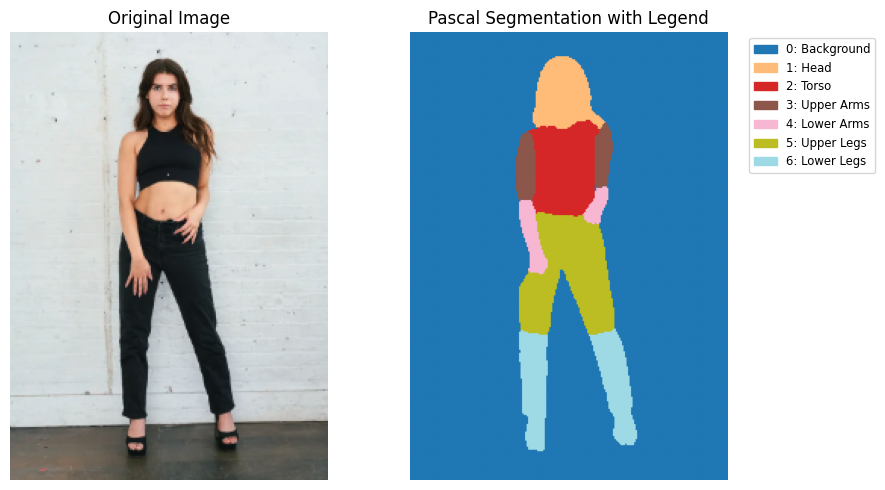

In [11]:
# Pascal-Person-Part: 7 labels
PASCAL_LABELS = {
    0: "Background",
    1: "Head",
    2: "Torso",
    3: "Upper Arms",
    4: "Lower Arms",
    5: "Upper Legs",
    6: "Lower Legs",
}

# --- Load and Run ---
pascal_model = load_schp_model("Self-Correction-Human-Parsing/exp-schp-201908270938-pascal-person-part.pth", num_classes=7)
pascal_segmentation_map = visualize_segmentation(person_path, pascal_model, PASCAL_LABELS)


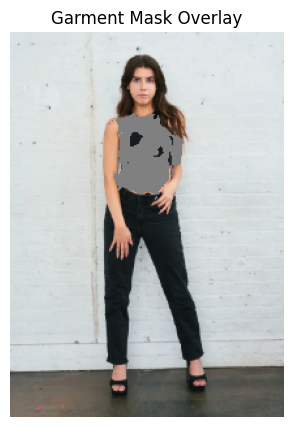

In [12]:
def extract_garment_mask(parsing, garment_name):
    garment_name = garment_name.lower()
    label_map = {
        "dress": [6],
        "upper-clothes": [5, 7],  # upper-clothes + coat
        "pants": [9],
        "skirt": [12],
        "jumpsuits": [10],
        "shoes": [18, 19],
        "arms": [14, 15],
        "legs": [16, 17], 
        "tank-top": [5]
    }

    target_labels = label_map.get(garment_name, [])
    if not target_labels:
        raise ValueError(f"Garment class '{garment_name}' not recognized.")

    mask = np.isin(parsing, target_labels).astype(np.uint8) * 255  # binary mask
    return mask

def overlay_mask(image_np, mask):
    overlaid = image_np.copy()
    overlaid[mask == 255] = [128, 128, 128]  # gray out
    return overlaid


garment_mask = extract_garment_mask(lip_segmentation_map, garment_name="tank-top")

# Step 3: Overlay
image_np = np.array(Image.open(person_path).convert("RGB"))
overlay = overlay_mask(image_np, garment_mask)

# Step 4: Display overlay
plt.figure(figsize=(10, 5))
plt.imshow(overlay)
plt.title("Garment Mask Overlay")
plt.axis("off")
plt.show()

